<a href="https://colab.research.google.com/github/deeponcology/PyTorchMedicalAI/blob/master/shlomo_lab_004_vgg_1408_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fixed Feature Extraction Using VGG

### DB:
https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria/downloads/cell-images-for-detecting-malaria.zip/1

### Paper:
https://arxiv.org/abs/1802.00752


### Sample notebook:
https://www.kaggle.com/ingbiodanielh/malaria-detection-with-fastai-v1

## Steps to solve the problem

- Extract bottleneck VGG features using a pre-trained model (VGG19)
- Construct several classifiers
    - Support Vector Machine
    - XGBoost
    - Simple Multi-Layered Perceptron
    - LightGBM 
    - Any CNN
- Predict labels

## Your task:
- look for "*YOUR CODE HERE*" and provide a solution

In [0]:
%reset -f
import os
import zipfile
import hashlib
from six.moves.urllib.error import URLError
from six.moves.urllib.request import urlretrieve
import argparse
from tqdm import tqdm
from keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_resnet, decode_predictions
from keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_inception
from keras.applications.vgg16 import VGG16, preprocess_input as preprocess_vgg
from keras.preprocessing import image
from keras import backend as K
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Concatenate
import numpy as np

import numpy as np
import pandas as pd
import time, os, glob
import cv2

from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD, Adam
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove

Using TensorFlow backend.


# Data set

Number of images: 27558


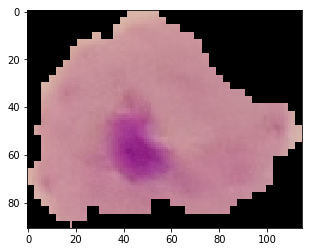

In [0]:
import os
from glob import glob
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

db="cell_images"
data_dir="/home/shlomo/" + db + "/"

imageList = glob(data_dir + '/**/*.png', recursive=True)
print ( "Number of images: {}". format (len (imageList)))
# for img in imageList[0:5]:
#     print(img)
    
%matplotlib inline
pil_im = Image.open(imageList[0], 'r')
imshow(np.asarray(pil_im))

# Define pre trained networks

In [0]:
from tqdm import tqdm # Enable progress bar
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions # Load pre-trained model
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Flatten, Input

    
class VGGFV:
    __name__ = "VGGFV"

    def __init__(self, input_size=224,num_class=1,batch_size=32):
        base_model = VGG16(weights='imagenet', include_top=False,
                           input_shape=[input_size,input_size,3], classes=num_class)
                                        
        x2 = GlobalAveragePooling2D()(base_model.get_layer("block2_conv2").output)  # 128
        x3 = GlobalAveragePooling2D()(base_model.get_layer("block3_conv3").output)  # 256
        x4 = GlobalAveragePooling2D()(base_model.get_layer("block4_conv3").output)  # 512
        x5 = GlobalAveragePooling2D()(base_model.get_layer("block5_conv3").output)  # 512        
        x = Concatenate()([x2,x3,x4,x5])        

        model = Model(inputs=base_model.input, outputs=x)        
        optimizer = Adam(lr=0.0001)
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
        
        self.model=model    
        self.batch_size = batch_size
        self.data_format = K.image_data_format()
    
    def predict(self, x):
        if self.data_format == "channels_first":
            x = x.transpose(0, 3, 1, 2)
        x = preprocess_vgg(x.astype(K.floatx()))
        return self.model.predict(x, batch_size=self.batch_size).squeeze()
    
    
def find_classes(fullDir):    
    print ("Full dir:{}".format(fullDir))
    classes = [d for d in os.listdir(fullDir) if os.path.isdir(os.path.join(fullDir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    num_to_class = dict(zip(range(len(classes)), classes))

    print('Sorted Classes: {}'.format(classes))
    print('class_to_idx: {}'.format(class_to_idx))
    print('num_to_class: {}'.format(num_to_class))

    train = []
    for index, label in enumerate(classes):
        path = fullDir + label + '/'
        for file in listdir(path):
            if file.endswith('tif') or file.endswith('jpg') or file.endswith('png'):
                train.append(['{}/{}/{}'.format(fullDir, label, file), label, index])

    df = pd.DataFrame(train, columns=['file', 'category', 'category_id', ])

    return classes, class_to_idx, num_to_class, df
    

# Test VGG feature extraction for a single image

In [0]:
# img_path = "plays.jpg"

input_size=224

img = image.load_img(imageList[0], target_size=(input_size, input_size))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_vgg(x)
print (x.shape)

model = VGGFV (input_size=input_size,num_class=1)
vgg_feature_vector = model.predict(x)
print (vgg_feature_vector.shape)
vgg_feature_vector

(1, 224, 224, 3)
(1408,)


array([4.6773944e+02, 1.6744505e+02, 8.1394203e+01, ..., 5.8332440e-02,
       1.1525798e+01, 0.0000000e+00], dtype=float32)

# Generate features for a full dataset

In [0]:
columns=['file', 'category_id', 'fv']
X_df_train=pd.DataFrame(data=np.zeros((0,len(columns))), columns=columns)
classes, class_to_idx, num_to_class, df= find_classes(data_dir)
print (class_to_idx)

# Empty arrays for storing extracted features
X_train = []; X_test = []

# Extract bottleneck features of photos for traninig    
for index, row in tqdm(df.iterrows()):
    img = image.load_img(row['file'], target_size=(input_size, input_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)    
    vgg_feature_vector = model.predict(x)
    X_train.append(vgg_feature_vector)
#     print (vgg_feature_vector)
    
    X_df_train = X_df_train.append({ 'file':row['file'], 
                              'category_id':row['category'],                               
                              'fv':vgg_feature_vector },
                                 ignore_index=True)
    

# X_df_train.category_id.astype(int)    
print(X_df_train.info())    

In [0]:
X_df_train.to_csv(str(model.__class__.__name__) + '_features_df.csv', index = False)
X_df_train.head(5)

In [0]:
import pandas 
X_df_train_SINGLE=X_df_train.copy(deep=True)
X_df_train_SINGLE.drop('file', axis=1, inplace=True)
answers_1_SINGLE = list (X_df_train_SINGLE['category_id'].values)
# answers_1_SINGLE= map(int, answers_1_SINGLE)
X_df_train_SINGLE = X_df_train_SINGLE.drop('category_id', axis=1)
X_df_train_SINGLE=X_df_train_SINGLE.apply(lambda x: pandas.to_numeric(x, errors='ignore'))

X_df_train_SINGLE.head(3)

,fv
0,"[366.5396, 149.68477, 61.79901, 207.61394, 273..."
1,"[154.18286, 123.3337, 48.969177, 187.62091, 17..."
2,"[386.05026, 117.52995, 59.7484, 203.23325, 301..."


In [0]:
# Function to make labels in the data frame into a list (i.e. 0 8 => [0, 8])
def labels_to_list(labels): *YOUR CODE HERE* 

# Process train & test set into an array format
X_train = *YOUR CODE HERE* 
Y_train = *YOUR CODE HERE* 

# Check shape of array-format train & test set
print("X_train: ", X_train.shape)
print("Y_train: ", Y_train.shape)

X_train:  (27558, 1408)
Y_train:  (27558, 1)


In [0]:
# Load packages for splitting train & validation set, XGBoost classifier, 1-of-K encoder

*YOUR CODE HERE* 

classifier.fit(X_train_, Y_train_)
# Show spent time
print("Time passed: ", "{0:.3f}".format(time.time() - t), "sec")


Time passed:  1366.752 sec


In [0]:
from sklearn.metrics import f1_score # For measuring F1 score metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix

import pickle
from sklearn.externals import joblib

# Predict labels using the trained model
# Y_predict = classifier.predict_proba(X_test_) # probs
# Predict labels using the trained model
Y_predict = classifier.predict(X_test_) # classes 

# Show some predicted values
print("Samples of predicted labels (in 1-of-K coding scheme):\n", Y_predict[1:8])
print("\nSamples of corresponding predicted labels:\n", one_of_K_encoder.inverse_transform(Y_predict[1:8]))

# Show global F1 score & on-label F1 score
print("Overall F1 score: ", f1_score(Y_test_, Y_predict, average='micro')) 
print("F1 score of each label : ", f1_score(Y_test_, Y_predict, average=None))

# save model to file
joblib.dump(classifier, (db + '_' + str(model.__class__.__name__) +  '_' + 
                         str (f1_score(Y_test_, Y_predict, average='micro')) + ".dat"))

Samples of predicted labels (in 1-of-K coding scheme):
 [[1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]]

Samples of corresponding predicted labels:
 [('Parasitized',), ('Uninfected',), ('Parasitized',), ('Uninfected',), ('Uninfected',), ('Parasitized',), ('Uninfected',)]
Overall F1 score:  0.9603700009068651
F1 score of each label :  [0.96026012 0.96048079]


['cell_images_VGGFV_0.9603700009068651.dat']

In [0]:
print (one_of_K_encoder.classes_)

['Parasitized' 'Uninfected']


Note that the several instances returned all zeroes, indicating that they matched none of the three labels fit

### CM
- input to confusion_matrix must be a list of predictions, not OHEs (one hot encodings).

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix

# labels = np.array([0, 1,2])
labels= one_of_K_encoder.classes_

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=None)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
#     plt.savefig(filename)

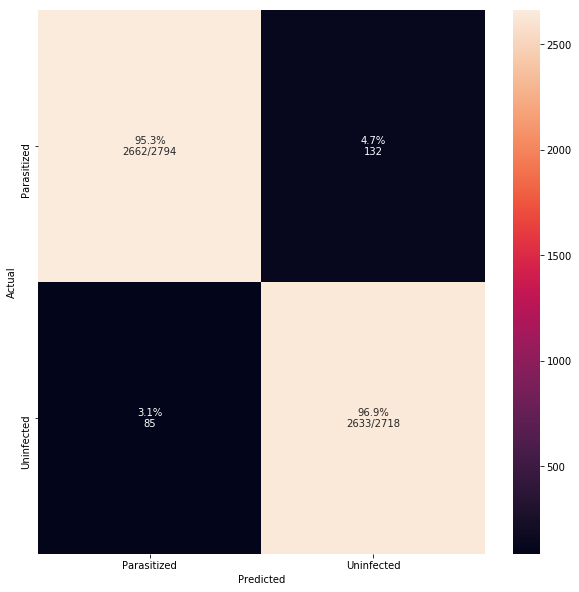

In [0]:
cm_analysis(Y_test_.argmax(axis=1), Y_predict.argmax(axis=1),labels)